# <center>Neural Machine Translation By Jointly Learning To Align And Translate</center>
<center> <strong> Submitted By : Aniruddha P. Deshpande (20161058) </strong> </center>
<center> <strong> Reference : </strong>
<a href="https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html" title="Pytorch Seq2Seq NMT Tutorial">Pytorch Seq2Seq NMT Tutorial</a>  </center>

### 1. Importing Libraries

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2. Defining language class for Input and Output languages

In [18]:
SOS_token = 0
EOS_token = 1

MAX_LENGTH = 109

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### 3. Text preprocessing functions

In [19]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

### 4. Reading Dataset and defining input and output language for the NMT

#### 4.1 Function for Reading data using above class Lang

In [20]:
def readLangs(lang1, lang2):
    lines_lang1 = open('../../Data/enghin/train.%s' % lang1, encoding='utf-8').\
        read().strip().split('\n')
    lines_lang2 = open('../../Data/enghin/train.%s' % lang2, encoding='utf-8').\
        read().strip().split('\n')

    train_pairs = []

    for i in range(0,len(lines_lang1)):
        curr_pair = [normalizeString(lines_lang1[i]), lines_lang2[i]]
        train_pairs.append(curr_pair)
    
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    
    return input_lang, output_lang, train_pairs

#### 4.2 Preparing data using above function

In [21]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [22]:
input_lang, output_lang, pairs = prepareData('en', 'hi')

Read 49398 sentence pairs
Counting words...
Counted words:
en 29852
hi 43667


### 5. Encoder

In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 6. Decoder

In [24]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 7. Training

#### 7.1 Preparing Training Data

In [25]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### 7.2 Train function

In [26]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### 7.3 Helper function to display time elapsed

In [27]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#### 7.4 Running Training Iterations (Epochs)

In [28]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

#### 7.5 Plotting Results

In [29]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 8. Evaluation

#### 8.1 Evaluation function

In [30]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#### 8.2 Evaluating randomly chosen pairs from the training set

In [31]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### 9. Training the model and then evaluating it using random pairs

16m 55s (- 236m 58s) (5000 6%) 5.7418
34m 52s (- 226m 41s) (10000 13%) 5.7088
53m 30s (- 214m 2s) (15000 20%) 5.6333
72m 50s (- 200m 20s) (20000 26%) 5.5319
91m 59s (- 183m 59s) (25000 33%) 5.4038
111m 28s (- 167m 12s) (30000 40%) 5.3148
130m 51s (- 149m 33s) (35000 46%) 5.2020
150m 15s (- 131m 28s) (40000 53%) 5.1616
169m 54s (- 113m 16s) (45000 60%) 5.0921
189m 45s (- 94m 52s) (50000 66%) 5.0720
209m 22s (- 76m 8s) (55000 73%) 4.9671
229m 12s (- 57m 18s) (60000 80%) 4.9453
248m 49s (- 38m 16s) (65000 86%) 4.9106
268m 37s (- 19m 11s) (70000 93%) 4.8705
288m 44s (- 0m 0s) (75000 100%) 4.8087


<Figure size 432x288 with 0 Axes>

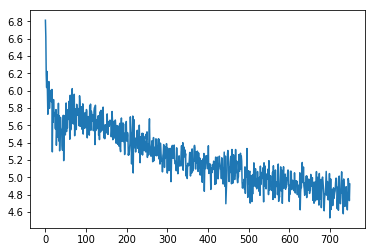

In [16]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [17]:
evaluateRandomly(encoder1, attn_decoder1)

> in this era of extreme industrial revolution fast developed aurangabad city has cherished its cultural heritage .
= तीव्र औद्योगिक क्रांति के इस युग में तेजी से विकसित हुए औरंगाबाद शहर ने अपनी सांस्कृतिक विरासत को सहेजकर रखा हुआ है ।
< इस शहर में इस शहर में में में में में में में में में में का । । <EOS>

> boil white onion .
= सफ़ेद प्याज को उबालें ।
< सफेद सफेद सफेद एक । । <EOS>

> the waterfall is part of the mankayam stream which rises from the agastya kund .
= इस जलराशि में जाने वाले को बहुत सावधानी से जाना चाहिए ।
< जो से के है से है जो है है । । । <EOS>

> according to symptoms medicines are as follows .
= लक्षणों के अनुसार औषधियाँ इस प्रकार हैं ।
< अनुसार के के के अनुसार के हैं । । हैं । <EOS>

> similarly this balasana could be done from either side .
= इसी प्रकार यह बालासन दूसरी ओर से किया जाता है ।
< इस तरह यह से से से से हैं । हैं । । <EOS>

> by doing this everyday the blackness will go .
= रोज ऐसा करने से कालापन दूर हो जाएगा ।
< ऐसा करने से इस को से की से । <EOS>

> the

In [18]:
torch.save(encoder1, '../../Models/Attn_Seq2Seq_NMT/Encoder/eng_to_hin_encoder.pth')
torch.save(attn_decoder1, '../../Models/Attn_Seq2Seq_NMT/Decoder/eng_to_hin_decoder.pth')

/home/aniruddha/.local/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aniruddha/.local/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [32]:
loaded_encoder = torch.load('../../Models/Attn_Seq2Seq_NMT/Encoder/eng_to_hin_encoder.pth')
loaded_decoder = torch.load('../../Models/Attn_Seq2Seq_NMT/Decoder/eng_to_hin_decoder.pth')

In [33]:
evaluateRandomly(loaded_encoder, loaded_decoder)

> can be reached here in three hours from pathankot .
= पठानकोट से यहाँ तीन घंटे में पहुँचा जा सकता है ।
< यहाँ तीन घंटे से तीन घंटे । <EOS>

> any one technique could be selected for massaging .
= मालिश के लिए कोई भी एक नुस्खा चुना जा सकता है ।
< एक भी भी भी है के है है है । है । <EOS>

> this is very near the border of china in north sikkim .
= यह उत्तर सिक्किम में चीन की सीमा के बहुत नजदीक है ।
< इस के यह में के के के में के है । <EOS>

> the cough can be dry and phlegmatic as well .
= खाँसी सूखी भी हो सकती है और बलगम वाली भी ।
< खाँसी और भी भी भी भी है । । है । <EOS>

> first that in which some part of the breast only is removed as per need .
= पहली वह जिसमें केवल ब्रेस्ट का आवश्यकतानुसार थोड़ा हिस्सा ही निकाला जाता है ।
< कुछ ही जो है है में है है जो में है में है में है है में है । । । है । <EOS>

> slowly try to bring the hand and legs together which will make the shape of the body like a chakra .
= धीरे-धीरे हाथ एवं पैरों को समीप लाने का प्रयत्‍न करें , जिससे शरीर की चक्र जैसी 